<a href="https://colab.research.google.com/github/hueglijoshua/CVI03.HS24-Computer-Vision/blob/main/object_detection_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detection using YOLO in keras

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

In [3]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 7.0 MB/s eta 0:00:00


In [4]:
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

In [6]:
dataset_path = "/content/drive/MyDrive/data_object_detection_yolo"
save_path = "/content/drive/MyDrive/yolo_models/"

class_mapping = {0: "fractured"}
MAX_BOXES = 5
bounding_box_format = "rel_xyxy"

In [5]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [75]:
# Paths for train, test, validation
split_folders = ["train", "test", "val"]
split_datasets = {}

def parse_yolo_annotation(txt_file, image_dir):
    """
    Reads YOLO-style annotation from a .txt file and converts it to bounding boxes & class IDs.
    """
    image_name = os.path.basename(txt_file).replace(".txt", ".jpg")
    image_path = os.path.join(image_dir, image_name)

    if not os.path.exists(image_path):
        print(f"Image file not found - {image_path}")

    boxes = []
    class_ids = []

    with open(txt_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # Convert YOLO format (x_center, y_center, w, h) → TensorFlow format (x_min, y_min, x_max, y_max)
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        boxes.append([x_min, y_min, x_max, y_max])
        class_ids.append(class_id)

    return image_path, boxes, class_ids


def create_tf_dataset(image_dir, label_dir):
    """
    Creates a TensorFlow dataset from image and annotation directories.
    """
    label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".txt")])

    image_paths = []
    bbox = []
    classes = []

    for txt_file in tqdm(label_files):
        image_path, boxes, class_ids = parse_yolo_annotation(txt_file, image_dir)
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

    # Convert to Ragged Tensors to handle variable-length bounding boxes
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.convert_to_tensor(image_paths)
    print(f"images shape: {image_paths.shape}")
    print(f"labels shape: {classes.shape}")
    print(f"bboxes shape: {bbox.shape}")

    # Create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

    return dataset


# Loop through train, test, and validation and create separate datasets
for split in split_folders:
    print(f"Creating {split} dataset...")
    image_dir = f"{dataset_path}/images/{split}"
    label_dir = f"{dataset_path}/labels/{split}"

    split_datasets[split] = create_tf_dataset(image_dir, label_dir)


Creating train dataset...


100%|██████████| 574/574 [00:04<00:00, 118.27it/s]


images shape: (574,)
labels shape: (574, None)
bboxes shape: (574, None, None)
Creating test dataset...


100%|██████████| 61/61 [00:00<00:00, 418.40it/s]


images shape: (61,)
labels shape: (61, None)
bboxes shape: (61, None, None)
Creating val dataset...


100%|██████████| 82/82 [00:00<00:00, 343.34it/s]

images shape: (82,)
labels shape: (82, None)
bboxes shape: (82, None, None)


In [31]:
def load_image(image_path):
    """
    Loads an image from a file path and ensures a consistent size.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (640, 640))
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image


# def load_dataset(image_path, classes, bbox):
#     image = load_image(image_path)
#     if isinstance(bbox, tf.RaggedTensor):
#         bbox = bbox.to_tensor(default_value=0.0)
#     if isinstance(classes, tf.RaggedTensor):
#         classes = classes.to_tensor(default_value=-1)

#     num_boxes = tf.shape(bbox)[0]

#     bounding_boxes = {
#         "classes": tf.cast(classes, dtype=tf.float32),
#         "boxes": bbox,
#     }
#     return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

def load_dataset(image_path, classes, bbox):
    image = load_image(image_path)

    if isinstance(bbox, tf.RaggedTensor):
        bbox = bbox.to_tensor(default_value=0.0)  # Convert to dense tensor (num_boxes, 4)
    if isinstance(classes, tf.RaggedTensor):
        classes = classes.to_tensor(default_value=-1)  # Convert to dense tensor (num_boxes,)

    # Expand classes to (num_boxes, 1) to match YOLOv8 expectations
    # classes = tf.expand_dims(classes, axis=-1)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }

    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}



## Data Augmentation

KerasCV natively supports bounding box augmentation with specialized layers. These layers automatically adjust bounding box coordinates during image transformations, maintaining accuracy and alignment. This allows us to integrate data augmentation into object detection workflows, improving training and model performance.

In [46]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=bounding_box_format),
        keras_cv.layers.RandomBrightness(factor=0.2,value_range=(0,255)),
        keras_cv.layers.RandomContrast(factor=0.2,value_range=(0,255)),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=bounding_box_format
        ),
    ]
)

## Create the train, validation and test splits

In [76]:
# Apply transformations to train, test, and val datasets
for split in split_folders:
    split_datasets[split] = (
        split_datasets[split]
        .map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)  # Load images & bounding boxes ONCE
        .shuffle(BATCH_SIZE * 4)  # Shuffle before batching
    )

In [77]:
train_ds = split_datasets["train"].batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = split_datasets["val"].batch(BATCH_SIZE, drop_remainder=True)
test_ds = split_datasets["test"].batch(BATCH_SIZE, drop_remainder=True)

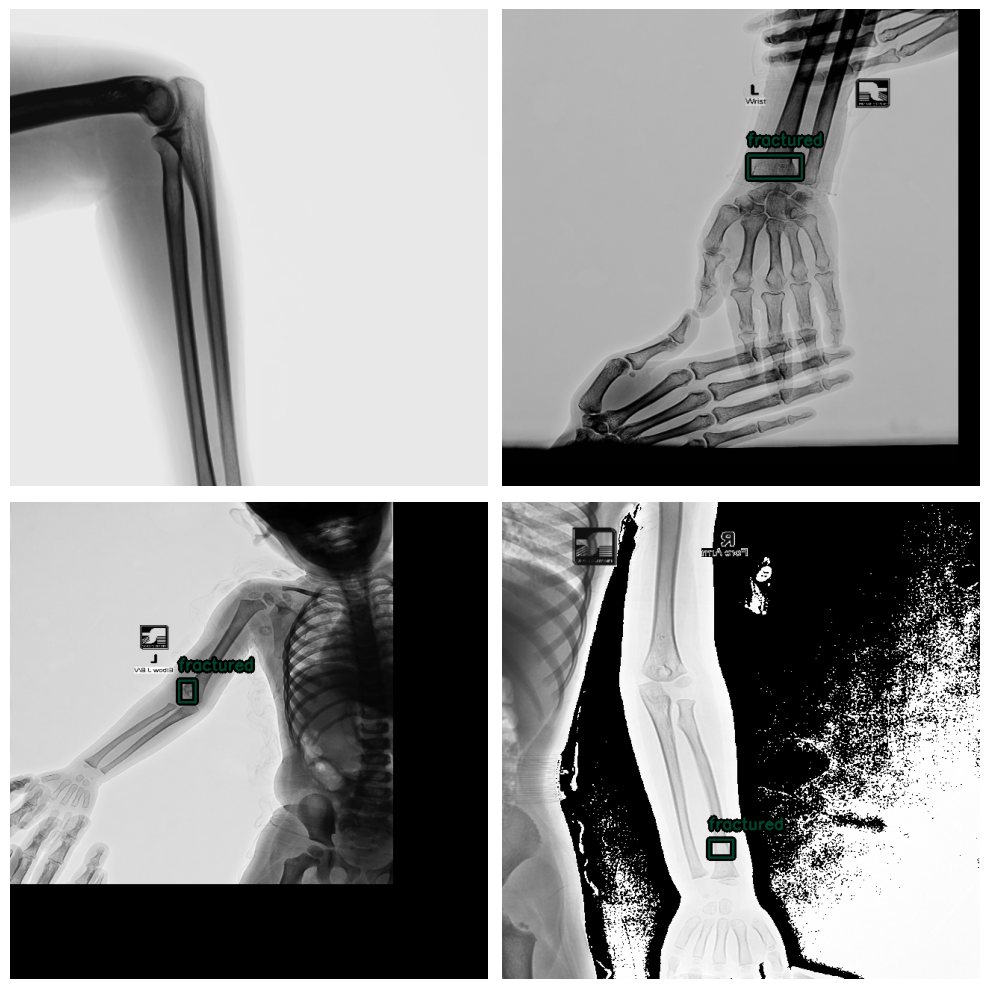

In [49]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format=bounding_box_format, value_range=(0, 1), rows=2, cols=2
)

We extract the inputs from the preprocessing dictionary and get them ready to be
fed into the model.

In [78]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## Create the model

In [16]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

100%|██████████| 646/646 [00:00<00:00, 440kB/s]


100%|██████████| 19.7M/19.7M [00:00<00:00, 29.4MB/s]


**Model Configuration:**
The **YOLOv8 Detector** is used for object detection on X-ray images, specifically for identifying bone fractures. The model is initialized with the following parameters:

- `num_classes=1`: The dataset contains a single class (`fractured`).
- `backbone=backbone`: A pre-trained YOLOv8 backbone is used for feature extraction.
- `fpn_depth=2`: A **Feature Pyramid Network (FPN)** with depth 2 is applied, improving the detection of fractures at different scales by fusing shallow and deep features.

In [80]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format=bounding_box_format,
    backbone=backbone,
    fpn_depth=1,
)

1. Classification Loss: This loss function calculates the discrepancy between anticipated
class probabilities and actual class and we use
`binary_crossentropy` for this binary classification task.

2. Box Loss: `box_loss` is the loss function used to measure the difference between the
predicted bounding boxes and the ground truth.

In [81]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [19]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format=bounding_box_format,
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [84]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, f"{save_path}_keras_model.keras")],
)

Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node yolov8_label_encoder_1_1/RaggedToTensor_1/RaggedTensorToTensor defined at (most recent call last):
<stack traces unavailable>
Detected at node yolov8_label_encoder_1_1/RaggedToTensor_1/RaggedTensorToTensor defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_94537[] on XLA_GPU_JIT: RaggedTensorToTensor (No registered 'RaggedTensorToTensor' OpKernel for XLA_GPU_JIT devices compatible with node {{node yolov8_label_encoder_1_1/RaggedToTensor_1/RaggedTensorToTensor}}){{node yolov8_label_encoder_1_1/RaggedToTensor_1/RaggedTensorToTensor}}
The op is created at: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 699, in <lambda>
File "/usr/local/lib/python3.11/dist-packages/tornado/ioloop.py", line 750, in _run_callback
File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 824, in inner
File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 785, in run
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper
File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.11/dist-packages/tornado/gen.py", line 233, in wrapper
File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-82-4ef253af8eba>", line 1, in <cell line: 0>
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data
File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_detector.py", line 526, in train_step
File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step
File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 387, in _compute_loss
File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_detector.py", line 555, in compute_loss
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_label_encoder.py", line 235, in call
File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/backend/scope.py", line 35, in wrapper
File "/usr/local/lib/python3.11/dist-packages/keras_cv/src/bounding_box/to_dense.py", line 73, in to_dense
	tf2xla conversion failed while converting __inference_one_step_on_data_94537[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_95973]

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format=bounding_box_format)